# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

Проверено:
1. Perfomance score от manager name не зависит
2. Продолжительность работы от брака не зависит
3. Прожолжительность работы не зависит от возраста
4. Perfomance score от age не зависит
5. Perfomance score от sex не зависит
6. Hispanic/Latino ни на что не влияет

In [1]:
import psycopg2
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)

hr_dataset = pd.read_sql_query("select * from hr_dataset", conn)
production_staff = pd.read_sql_query("select * from production_staff", conn)
recruiting_costs = pd.read_sql_query("select * from recruiting_costs", conn)
salary_grid = pd.read_sql_query("select * from salary_grid", conn)

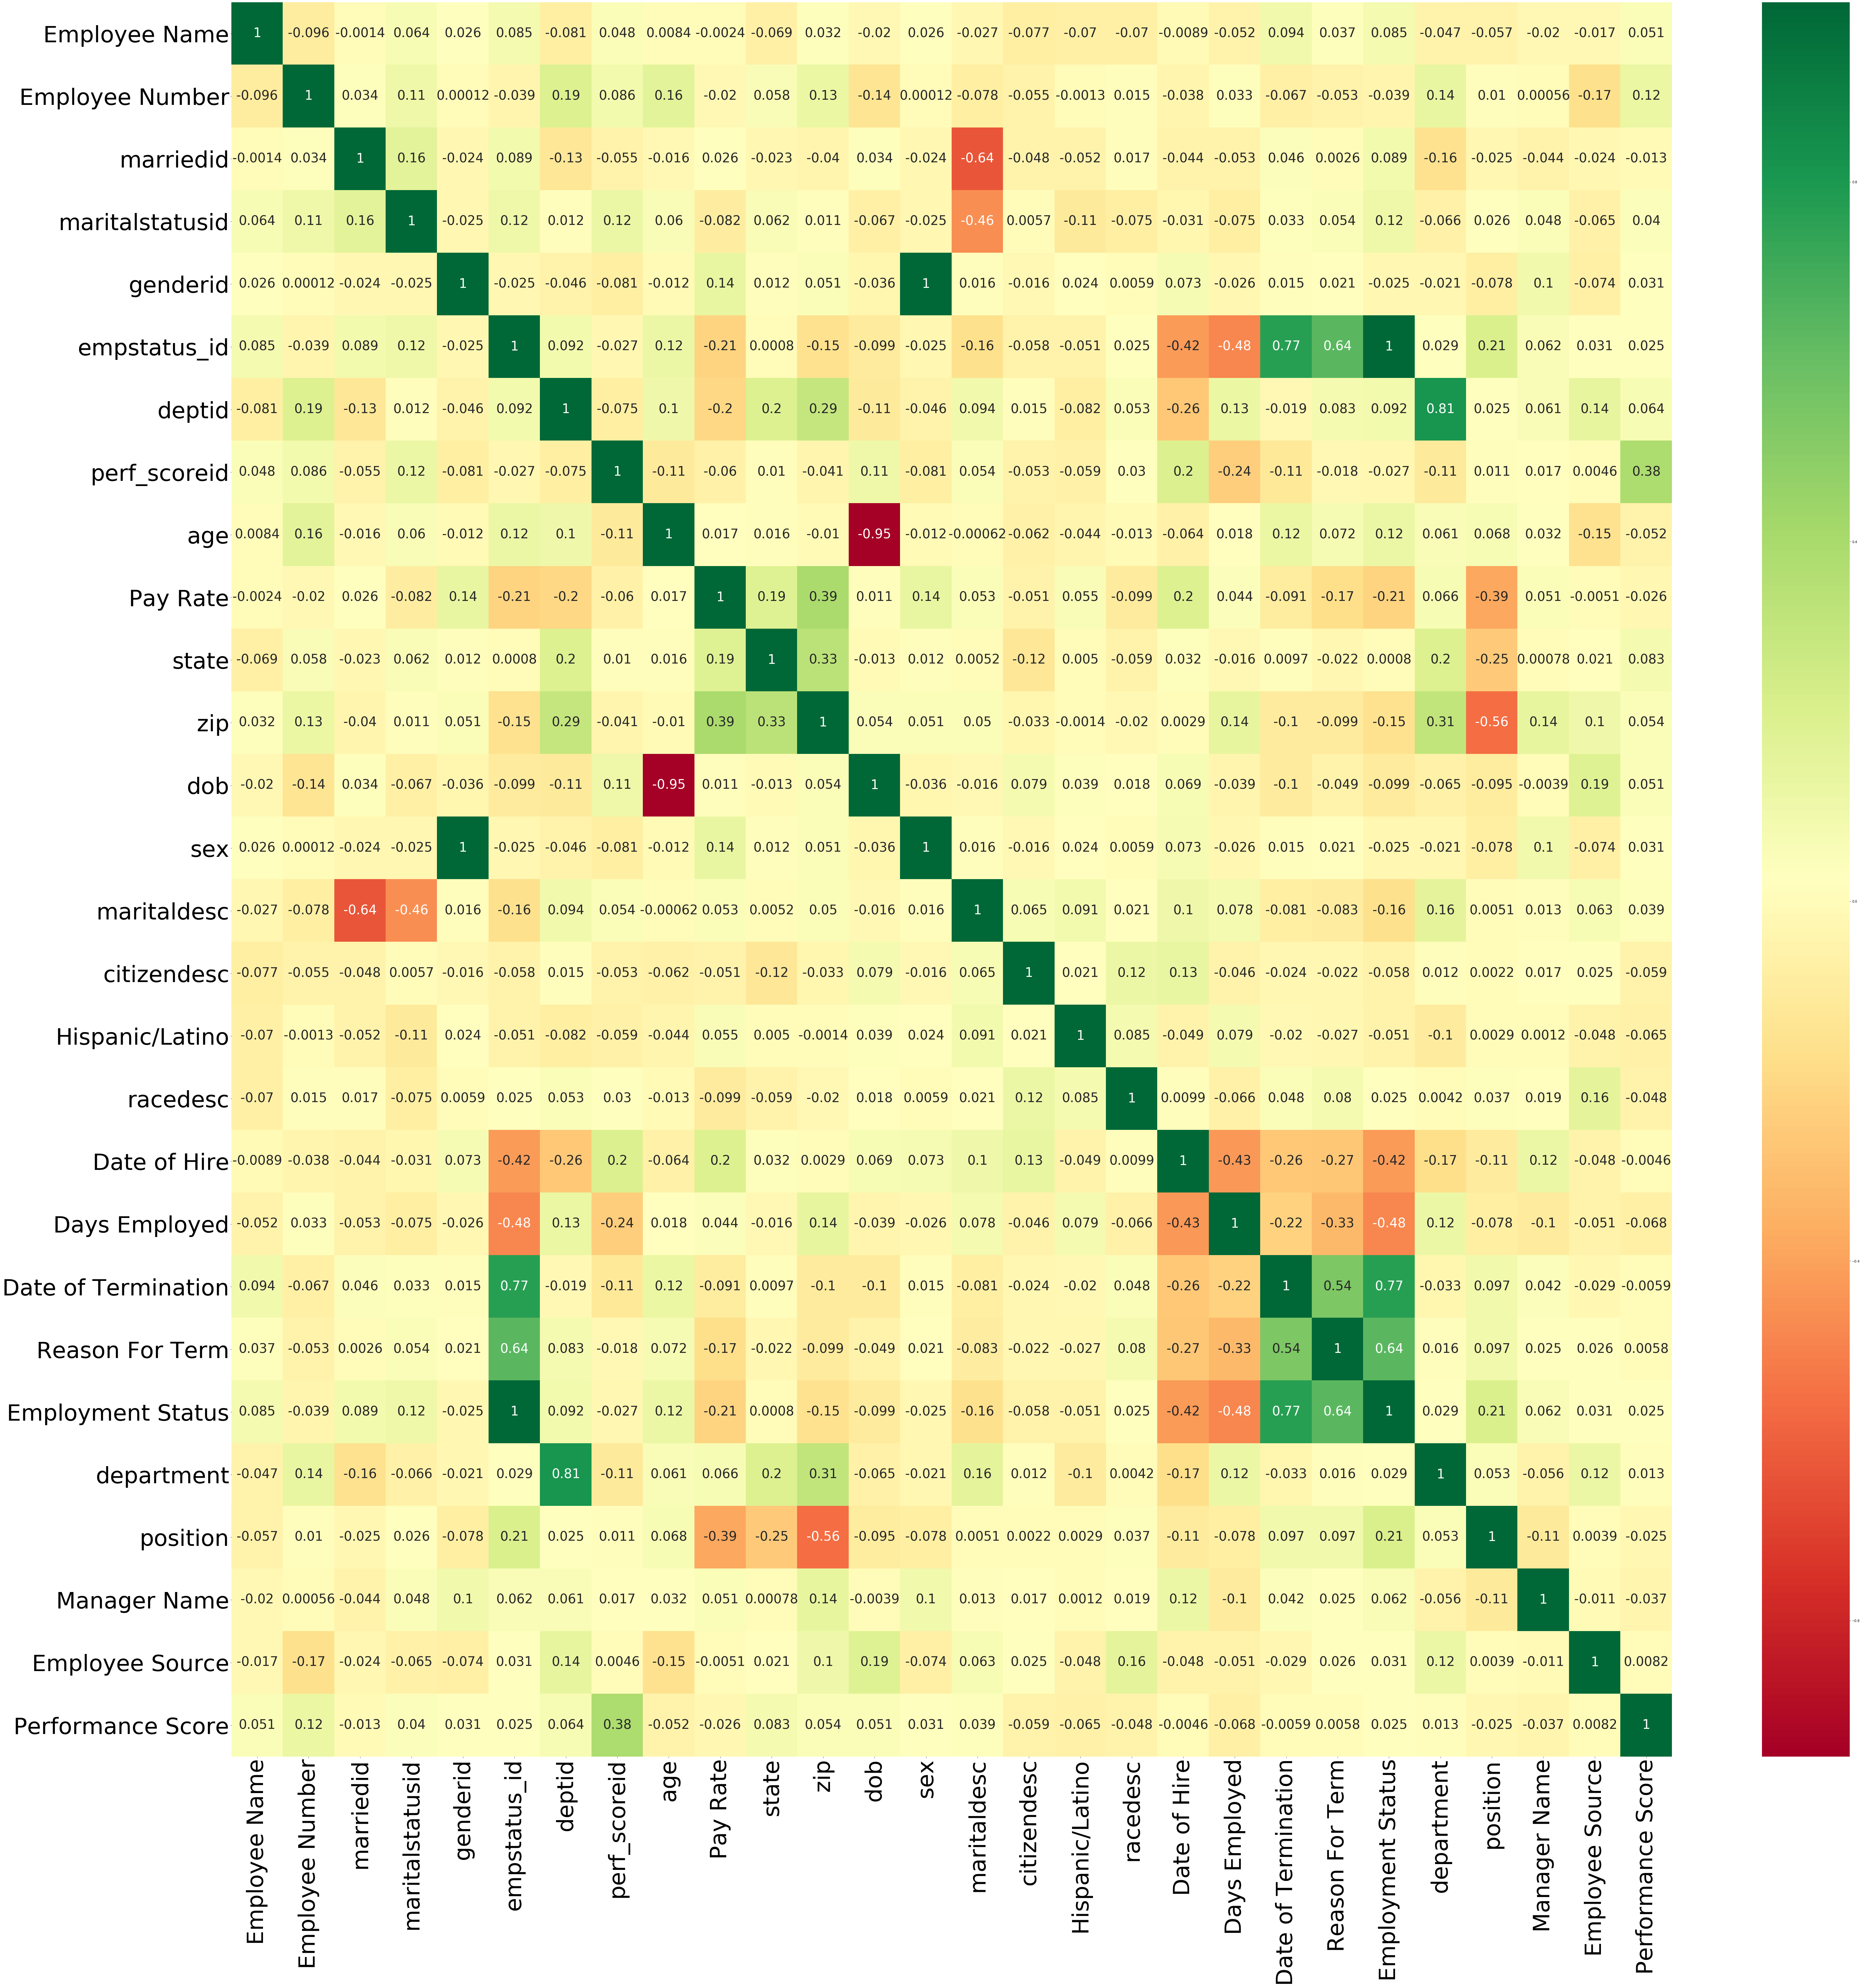

In [2]:
df = hr_dataset.copy().drop(columns=['id'])
df.loc[:, df.dtypes == 'object'] =\
    df.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category').cat.codes)

df_corr = df.corr()
fig, ax = plt.subplots(figsize=(100,100))  
ax = sns.heatmap(df_corr, cmap='RdYlGn', annot=True, ax=ax, annot_kws={"size": 40})
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5) 
plt.xticks(fontsize=70, rotation=90)
plt.yticks(fontsize=70, rotation=0)
plt.show()

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [106]:
import requests
import datetime
import dateutil.relativedelta
from datetime import date
from datetime import datetime, timedelta
import pandas as pd

vk_token = "bfb950019e714023815a10d32bff3ceeb1a1334df2a847d4804c64ae07f031e306902addb08b8e86788ee"

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

month_ago = datetime.combine(date.today() - dateutil.relativedelta.relativedelta(years=1), datetime.min.time())
date_of_last_post = datetime.today()

offset = 1

df =  pd.DataFrame()

while (date_of_last_post > month_ago):
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=' + str(offset) + '&count=100&v=5.92'
    response = getjson(url)
    for item in response['response']['items']:
        date_of_last_post = (datetime.fromtimestamp(item['date']) - timedelta(hours=0))
        df = df.append(pd.DataFrame([[
            date_of_last_post,
            item['post_type'],
            item['text'],
            [x['type'] for x in item['attachments']],
            item['comments']['count'],
            item['likes']['count'],
            item['reposts']['count'],
            item['views']['count']]], columns=['date', 'post_type', 'text', 'attachments_types', 'comments', 'likes', 'reposts', 'views']))
    offset += 100

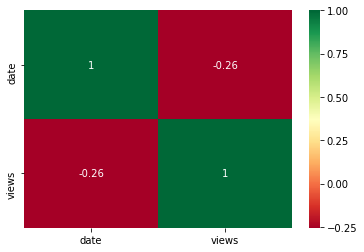

In [109]:
import numpy as np

df_copy = df[['date', 'views']].copy()
df_copy.date = [x.hour for x in df.date]
df_corr = df_copy.corr()
fig, ax = plt.subplots()  
ax = sns.heatmap(df_corr, cmap='RdYlGn', annot=True, ax=ax)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5) 
plt.show()

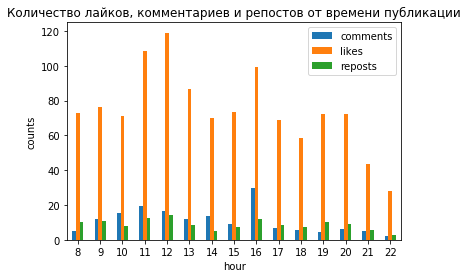

In [110]:
df_copy = df[['date', 'views', 'comments', 'likes', 'reposts']].copy()
df_copy.date = [x.hour for x in df.date]
ax = df_copy.groupby('date')[['comments', 'likes', 'reposts']].mean().plot.bar()
ax.set_xlabel('hour')
ax.set_ylabel('counts')
ax.set_title('Количество лайков, комментариев и репостов от времени публикации')
plt.xticks(rotation=0)
plt.show()

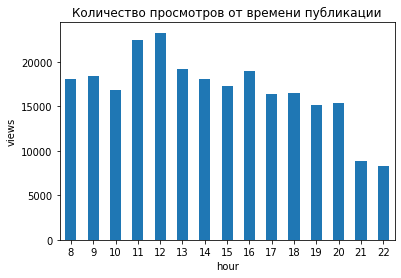

In [111]:
df_copy = df[['date', 'views']].copy()
df_copy.date = [x.hour for x in df.date]
ax = df_copy.groupby('date')['views'].mean().plot.bar()
ax.set_xlabel('hour')
ax.set_ylabel('views')
ax.set_title('Количество просмотров от времени публикации')
plt.xticks(rotation=0)
plt.show()

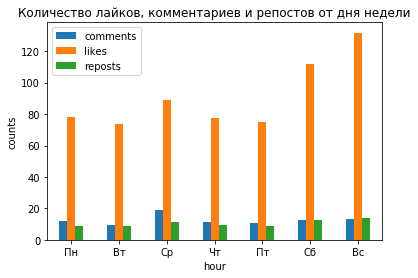

In [112]:
df_copy = df[['date', 'views', 'comments', 'likes', 'reposts']].copy()
df_copy.date = [x.weekday() for x in df.date]
ax = df_copy.groupby('date')[['comments', 'likes', 'reposts']].mean().plot.bar()
ax.set_xlabel('hour')
ax.set_ylabel('counts')
ax.set_xticklabels(['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])
ax.set_title('Количество лайков, комментариев и репостов от дня недели')
plt.xticks(rotation=0)
plt.show()

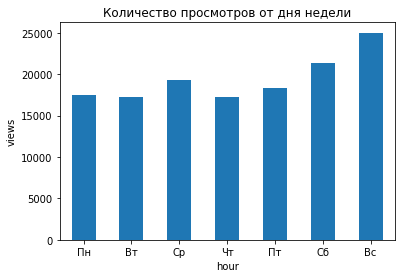

In [113]:
df_copy = df[['date', 'views']].copy()
df_copy.date = [x.weekday() for x in df.date]
ax = df_copy.groupby('date')['views'].mean().plot.bar()
ax.set_xlabel('hour')
ax.set_ylabel('views')
ax.set_xticklabels(['Пн','Вт','Ср','Чт','Пт','Сб','Вс'])
ax.set_title('Количество просмотров от дня недели')
plt.xticks(rotation=0)
plt.show()

In [147]:
rubrics

{'#Skillbox_DMC',
 '#Skillbox_Mildberry',
 '#Skillbox_OFFF',
 '#Skillbox_Pinkman',
 '#Skillbox_Sreda',
 '#Skillbox_TED',
 '#Skillbox_Дизайн',
 '#Skillbox_Маркетинг',
 '#Skillbox_Мркетинг',
 '#Skillbox_Программирование',
 '#Skillbox_РАНХиГС',
 '#Skillbox_РБК',
 '#Skillbox_Симпсоны',
 '#Skillbox_Сострадамус',
 '#Skillbox_Управление',
 '#Skillbox_акция',
 '#Skillbox_в_закладки',
 '#Skillbox_вдохновляет',
 '#Skillbox_взакладки',
 '#Skillbox_вопросы',
 '#Skillbox_геймдизайн',
 '#Skillbox_дизайн',
 '#Skillbox_игра',
 '#Skillbox_кейс',
 '#Skillbox_конкурс',
 '#Skillbox_курс',
 '#Skillbox_маркетинг',
 '#Skillbox_образование',
 '#Skillbox_подкаст',
 '#Skillbox_программирование',
 '#Skillbox_разработка',
 '#Skillbox_управление'}

In [159]:
re.findall(r'((#[^ ]+(Skillbox))|(#(Skillbox)[^ ]+))', '#Конкурс_Skillbox #vktalents_bomman #В_закладки_Skillbox #Skillbox_программирование')

[('#Конкурс_Skillbox', '#Конкурс_Skillbox', 'Skillbox', '', ''),
 ('#В_закладки_Skillbox', '#В_закладки_Skillbox', 'Skillbox', '', ''),
 ('#Skillbox_программирование',
  '',
  '',
  '#Skillbox_программирование',
  'Skillbox')]

In [150]:
import re

rubrics = set()

for t in df.text:
    for x in re.findall(r'#(Skillbox_[^ ])|(.+Skillbox)', t):
        rubrics.add(x.strip())

AttributeError: 'tuple' object has no attribute 'strip'